In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# ML Libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load data
df = pd.read_csv(r'C:\Users\Sony\Desktop\marketing_clean.csv')


K-MEANS CLUSTERING
Features Shape: (588101, 5)
feature : ['test_group', 'converted', 'total_ads', 'most_ads_hour', 'day_numeric']
Scaled data Shape: (588101, 5)

Finding optimal k using Elbow Method...
 K=2: Inertia=2496930.84
 K=3: Inertia=1743843.49
 K=4: Inertia=1329767.44
 K=5: Inertia=1111261.43
 K=6: Inertia=862981.54


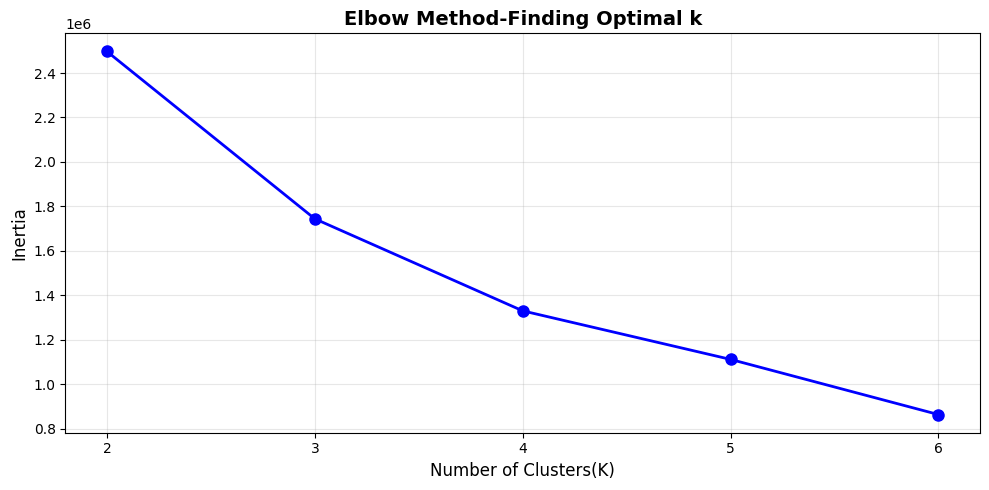

In [ ]:
# Prepare features for clustering
print("\n" + "="*60)
print("K-MEANS CLUSTERING")
print("=" * 60)

# Start timer
start_time = time.time()

# Select features for clustering
features_for_clustering  = df[['test_group', 'converted','total_ads', 'most_ads_hour']].copy()

# Encode day as a single numeric variable(weekday number)
day_mapping= {
    'Monday' : 1, 'Tuesday':2, 'Wednesday' :3, 'Thursday': 4,
    'Friday' : 5, 'Saturday' :6, 'Sunday' :7
}
features_for_clustering['day_numeric']=df['most_ads_day'].map(day_mapping)

# Check for Missing Values
features_for_clustering = features_for_clustering.dropna()

print(f"Features Shape: {features_for_clustering.shape}")
print(f"feature : {list(features_for_clustering.columns)}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)
print(f"Scaled data Shape: {X_scaled.shape}")

# Elbow Method to find optimal K
print("\nFinding optimal k using Elbow Method...")
inertias =[]
K_range = range(2,7)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=3, max_iter=100)
    kmeans_temp.fit(X_scaled)
    inertias.append(kmeans_temp.inertia_)
    
    print(f" K={k}: Inertia={kmeans_temp.inertia_:.2f}")   

# Plot Elbow curve
plt.figure(figsize=(10,5))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters(K)', fontsize=12)
plt.ylabel('Inertia',fontsize=12)
plt.title('Elbow Method-Finding Optimal k', fontsize=14, fontweight='bold')
plt.xticks(K_range)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('elbow_method_fast.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# Use optimal k (let's say k=4 based on elbow)

# Choose Optimal k (usually 4 Based on Bussiness logic)
optimal_k = 4
Kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=5, max_iter=200)

# Fit and Predict
clusters = Kmeans_final.fit_predict(X_scaled)

# Add clusters to original dataframe
df['cluster'] = clusters

print(f"\nClustering completed with k={optimal_k}")
print(f"Cluster distribution:\n{df['cluster'].value_counts().sort_index()}")

# Analyze clusters
print("\n" + "="*50)
print("ANALYSING CLUSTER CHARACTERISTICS...")
print("="*50)

cluster_summary = df.groupby('cluster').agg({
    'user_id' : 'count',
    'converted' : [ 'sum','mean'],
    'total_ads' : 'mean',
    'most_ads_hour' : 'mean',
    'test_group' : 'mean'
}).round(2)

cluster_summary.columns= ['Count', 'Conversions', 'Conv_Rate', 'Avg_Ads', 'Avg_Hour', 'Test_Pct']

print("\nCluster Summary:")
print(cluster_summary)

# Name clusters based on characteristics
cluster_names = {}
for cluster_id in range(optimal_k):
    cluster_data = df[df['cluster']== cluster_id]
    avg_conversion = cluster_data['converted'].mean()
    avg_ads = cluster_data['total_ads'].mean()

    if avg_conversion > 0.35 and avg_ads < 15:
        cluster_names[cluster_id] = 'High-Intent converters'
    elif avg_conversion < 0.15 and avg_ads > 20 :
        cluster_names[cluster_id] = 'Ad-Resistant'   
    elif avg_conversion > 0.2 :
        cluster_names[cluster_id] = 'Engaged Users'   
    else:
        cluster_names[cluster_id] = 'Low Engagement'

print("\n" + "="*50)      
print("CLUSTER NAMING")
print("="*50)  
for cluster_id, name in cluster_names.items():
    print(f"Cluster {cluster_id}: {name}")



Clustering completed with k=4
Cluster distribution:
cluster
0    266625
1    283206
2     15167
3     23103
Name: count, dtype: int64

ANALYSING CLUSTER CHARACTERISTICS...

Cluster Summary:
          Count  Conversions  Conv_Rate  Avg_Ads  Avg_Hour  Test_Pct
cluster                                                             
0        266625            0       0.00    21.82     13.75      1.00
1        283206            0       0.00    23.83     15.13      1.00
2         15167        14843       0.98    97.85     15.02      0.97
3         23103            0       0.00    23.66     14.29      0.00

CLUSTER NAMING
Cluster 0: Ad-Resistant
Cluster 1: Ad-Resistant
Cluster 2: Engaged Users
Cluster 3: Ad-Resistant


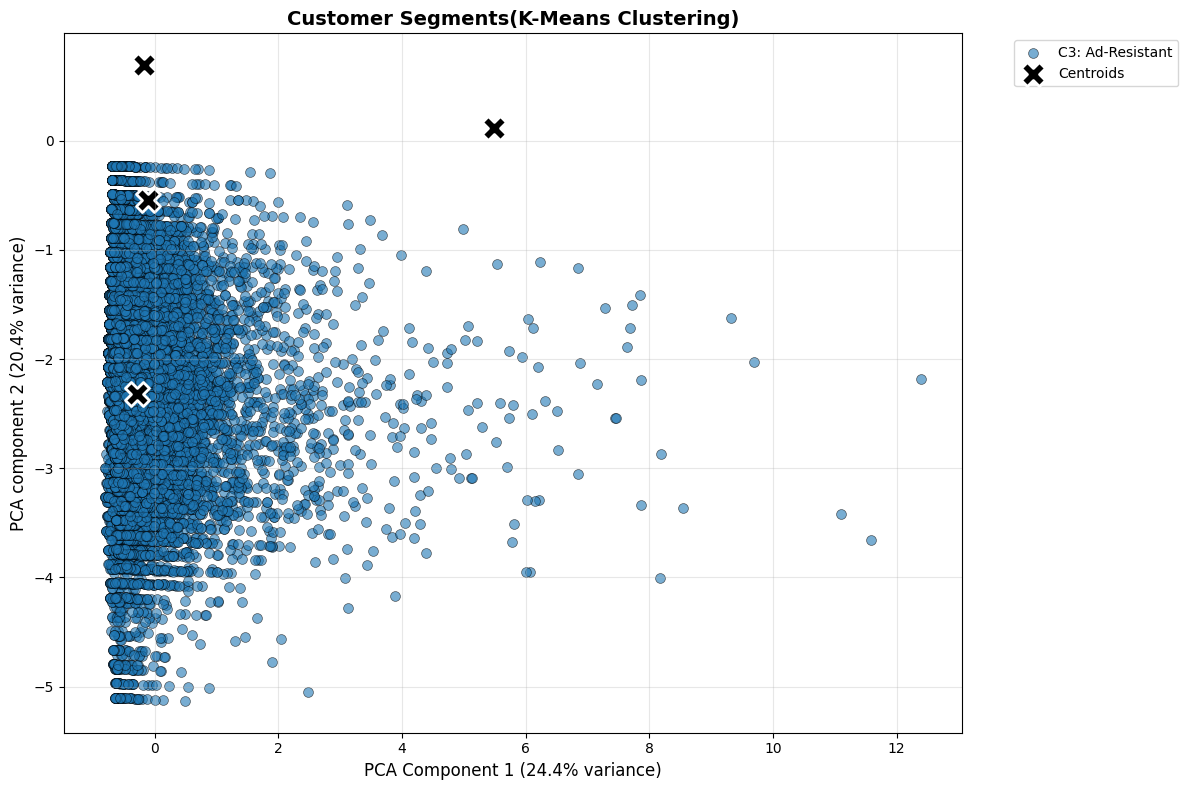


PCA Explained Variance: [0.24369751 0.20395918]
Total variance explained : 44.77%


In [ ]:
# PCA for visualizations
pca= PCA(n_components=2,random_state=42)    
X_pca= pca.fit_transform(X_scaled)

df['pca1'] = X_pca[:,0]
df['pca2'] = X_pca[:,1]

# plot clusters
plt.figure(figsize=(12,8))

for i, (cluster_id, name) in enumerate(cluster_names.items()):
    cluster_data = df[df['cluster'] == cluster_id]
plt.scatter(x=cluster_data['pca1'], y=cluster_data['pca2'], s=50, alpha=0.6, edgecolors='black', linewidths=0.5, label=f"C{cluster_id}: {name}")

# plot centroids
centroids_pca= pca.transform(Kmeans_final.cluster_centers_)

plt.scatter(
    centroids_pca[:,0],
    centroids_pca[:,1],
    c= 'black',
    marker= 'X',
    s=300,
    label='Centroids',
    edgecolors='white', linewidth=2)

plt.title('Customer Segments(K-Means Clustering)', fontsize=14, fontweight='bold')
plt.xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
plt.ylabel(f'PCA component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('customer_segments_fast.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPCA Explained Variance: {pca.explained_variance_ratio_}")
print(f"Total variance explained : {pca.explained_variance_ratio_.sum()*100:.2f}%")

In [ ]:
print("\n" + "="*60)
print("DETAILED CLUSTER PROFILES")
print("=" * 60)

for cluster_id in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster_id]
    print(f"\n{"="*60}")
    print(f"CLUSTER {cluster_id}: {cluster_names[cluster_id]}")
    print(f"{"="*60}")
    print(f"Size:{len(cluster_data)} users ({len(cluster_data)/len(df)*100:.1f}% of total)")
    print(f"Conversion Rate : {cluster_data['converted'].mean()*100:.2f}%")
    print(f"Avg ads Shown : {cluster_data['total_ads'].mean():.2f}")
    print(f"Avg Peak Hour: {cluster_data['most_ads_hour'].mean():.2f}")
    print(f"Test Group % : {cluster_data['test_group'].mean()*100:.1f}")
    print(f"Most Common Day: {cluster_data['most_ads_day'].mode()[0]}")



DETAILED CLUSTER PROFILES

CLUSTER 0: Ad-Resistant
Size:266625 users (45.3% of total)
Conversion Rate : 0.00%
Avg ads Shown : 21.82
Avg Peak Hour: 13.75
Test Group % : 100.0
Most Common Day: Monday

CLUSTER 1: Ad-Resistant
Size:283206 users (48.2% of total)
Conversion Rate : 0.00%
Avg ads Shown : 23.83
Avg Peak Hour: 15.13
Test Group % : 100.0
Most Common Day: Friday

CLUSTER 2: Engaged Users
Size:15167 users (2.6% of total)
Conversion Rate : 97.86%
Avg ads Shown : 97.85
Avg Peak Hour: 15.02
Test Group % : 97.2
Most Common Day: Monday

CLUSTER 3: Ad-Resistant
Size:23103 users (3.9% of total)
Conversion Rate : 0.00%
Avg ads Shown : 23.66
Avg Peak Hour: 14.29
Test Group % : 0.0
Most Common Day: Thursday


In [ ]:
# Step 9 : Save results

# Save dataframe with clusters
df.to_csv('marketing_with_clusters.csv', index=False)
print(" Saved: Marketing_with_clusters.csv")

# Save cluster summary
cluster_summary.to_csv('cluster_summary.csv')
print(" Saved: cluster_summary.csv")

# Export segment summary
segment_summary =df.groupby('cluster').agg({
    'user_id' : 'count',
    'converted' : [ 'sum','mean'],
    'total_ads' : 'mean',
    'most_ads_hour' : 'mean',
    'test_group' : 'mean'
}).round(2)
segment_summary.to_csv('segment_summary.csv')  
print(" saved : segment_summary.csv")  


 Saved: Marketing_with_clusters.csv
 Saved: cluster_summary.csv
 saved : segment_summary.csv
